In [1]:
# !pip install "gymnasium[other]"

In [2]:
from typing import Optional
import numpy as np
import gymnasium as gym

In [3]:
class SnakeEnv(gym.Env):

    def __init__(self, size: int = 5):
        # The size of the square grid (5x5 by default)
        self.size = size

        # Initialize positions - will be set randomly in reset()
        # Using -1,-1 as "uninitialized" state
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)

        # Define what the agent can observe
        # Dict space gives us structured, human-readable observations
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),   # [x, y] coordinates
                "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),  # [x, y] coordinates
            }
        )

        # Define what actions are available (4 directions)
        self.action_space = gym.spaces.Discrete(4)

        # Map action numbers to actual movements on the grid
        # This makes the code more readable than using raw numbers
        self._action_to_direction = {
            0: np.array([0, 1]),   # Move right (column + 1)
            1: np.array([-1, 0]),  # Move up (row - 1)
            2: np.array([0, -1]),  # Move left (column - 1)
            3: np.array([1, 0]),   # Move down (row + 1)
        }

    def _get_obs(self):
        """Convert internal state to observation format.

        Returns:
            dict: Observation with agent and target positions
        """
        return {"agent": self._agent_location, "target": self._target_location}
    
    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info with distance between agent and target
        """
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # Randomly place the agent anywhere on the grid
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # Randomly place target, ensuring it's different from agent position
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info
    
    def step(self, action):
        """Execute one timestep within the environment.

        Args:
            action: The action to take (0-3 for directions)

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
        """
        # Map the discrete action (0-3) to a movement direction
        direction = self._action_to_direction[action]

        # Update agent position, ensuring it stays within grid bounds
        # np.clip prevents the agent from walking off the edge
        dead = max(self._agent_location + direction) >= self.size or min(self._agent_location + direction)<0

        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        # Check if agent reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        

        # We don't use truncation in this simple environment
        # (could add a step limit here if desired)
        truncated = False

        # Simple reward structure: +1 for reaching target, 0 otherwise
        # Alternative: could give small negative rewards for each step to encourage efficiency
        reward = 1 if terminated else -10 if dead else -0.01

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info
    
    def render(self):
        """Render the environment for human viewing."""
        if self.render_mode == "human":
            # Print a simple ASCII representation
            for y in range(self.size - 1, -1, -1):  # Top to bottom
                row = ""
                for x in range(self.size):
                    if np.array_equal([x, y], self._agent_location):
                        row += "A "  # Agent
                    elif np.array_equal([x, y], self._target_location):
                        row += "T "  # Target
                    else:
                        row += ". "  # Empty
                print(row)
            print()



In [4]:
# Register the environment so we can create it with gym.make()
gym.register(
    id="gymnasium_env/SnakeEnv-v0",
    entry_point=SnakeEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)

In [5]:
env = gym.make("gymnasium_env/SnakeEnv-v0", size=10)
env.unwrapped.size

10

In [6]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


d:\Dev_python\Anaconda\Lib\site-packages\gymnasium\utils\env_checker.py:384: UserWarning: WARN: The environment (<TimeLimit<OrderEnforcing<PassiveEnvChecker<SnakeEnv<gymnasium_env/SnakeEnv-v0>>>>>) is different from the unwrapped version (<SnakeEnv<gymnasium_env/SnakeEnv-v0>>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(


In [11]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class SnakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Q-Learning agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """Choose an action using epsilon-greedy strategy.

        Returns:
            action: 0 (stand) or 1 (hit)
        """
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            state = self.obs_to_state(obs)
            return int(np.argmax(self.q_values[state]))

        
    def obs_to_state(self, obs: dict) -> tuple[int, int, int, int]:
        ax, ay = int(obs["agent"][0]), int(obs["agent"][1])
        tx, ty = int(obs["target"][0]), int(obs["target"][1])
        return (ax, ay, tx, ty)

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict,
    ):
        """Update Q-value based on experience.

        This is the heart of Q-learning: learn from (state, action, reward, next_state)
        """

        state = self.obs_to_state(obs)
        next_state = self.obs_to_state(next_obs)
        # What's the best we could do from the next state?
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * np.max(self.q_values[next_state])

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[state][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[state][action] = (
            self.q_values[state][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [14]:
# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 10000        # Number of game played
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration

# Create environment and agent
env = gym.make("gymnasium_env/SnakeEnv-v0")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = SnakeAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=0.95,
)

In [15]:
from tqdm import tqdm  # Progress bar

for episode in tqdm(range(n_episodes)):
    # Start game
    obs, info = env.reset()
    terminated = False
    truncated = False
    dead = False

    # Play one move
    while not (terminated or truncated):
        # Agent chooses action (initially random, gradually more intelligent)
        action = agent.get_action(obs)

        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Learn from this experience
        dead = bool(info.get("dead", False))
        done = terminated or truncated or dead

        agent.update(obs, action, reward, done, next_obs)

        # Move to next state
        obs = next_obs

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()

100%|██████████| 10000/10000 [00:02<00:00, 4839.71it/s]


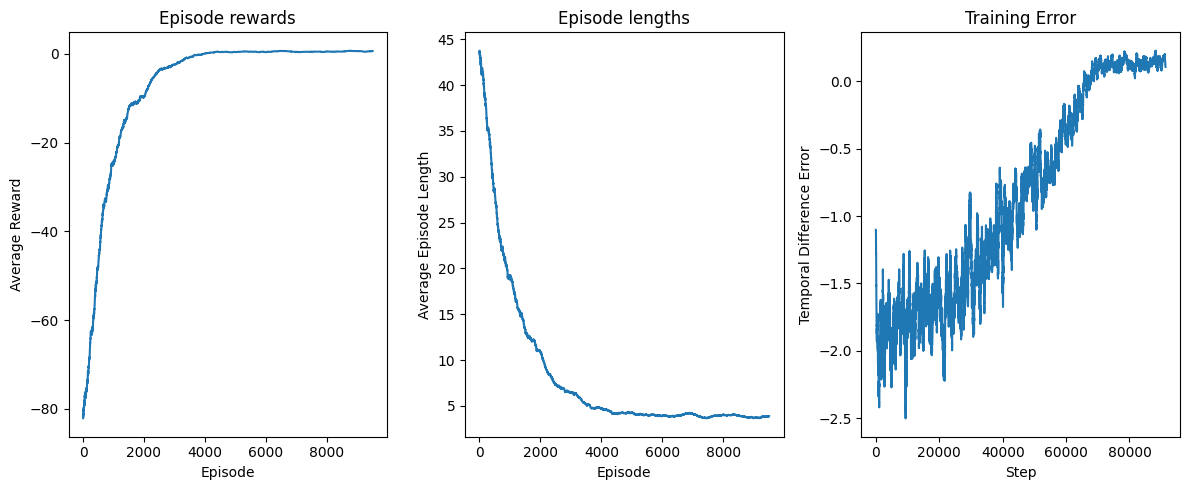

In [16]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [17]:
import numpy as np

def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0.0
        terminated = False
        truncated = False
        dead = False

        while not (terminated or truncated or dead):
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            dead = bool(info.get("dead", False))
            episode_reward += reward

        total_rewards.append(episode_reward)

    agent.epsilon = old_epsilon

    total_rewards = np.array(total_rewards, dtype=float)
    win_rate = np.mean(total_rewards > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")


In [18]:
# Test your agent
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 98.7%
Average Reward: 0.925
Standard Deviation: 0.451
